<a href="https://colab.research.google.com/github/chalini99/Machine-learning/blob/main/Dogbreed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chaliniii","key":"25462b750c2b324711c70c2077035cf2"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c dog-breed-identification


 98% 679M/691M [00:01<00:00, 266MB/s]
100% 691M/691M [00:01<00:00, 378MB/s]


In [5]:
!unzip -q dog-breed-identification.zip -d dataset



In [6]:
!ls /content


dataset  dog-breed-identification.zip  drive  kaggle.json  sample_data


In [7]:
!cp -r /content/dataset /content/drive/MyDrive/dog_breed_dataset_backup



In [8]:
!ls ~/.kaggle




kaggle.json


In [9]:
!ls /content/dataset


labels.csv  sample_submission.csv  test  train


In [10]:
!nvidia-smi


Tue Nov 18 17:26:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [11]:
import pandas as pd
import shutil
import os

labels = pd.read_csv("/content/dataset/labels.csv")
train_path = "/content/dataset/train"
sorted_path = "/content/sorted_dataset"

# Reset folder if exists
if os.path.exists(sorted_path):
    shutil.rmtree(sorted_path)
os.makedirs(sorted_path)

# Create breed folders
for breed in labels["breed"].unique():
    os.makedirs(f"{sorted_path}/{breed}", exist_ok=True)

# Copy each image into its breed folder
for _, r in labels.iterrows():
    src = f"{train_path}/{r['id']}.jpg"
    dst = f"{sorted_path}/{r['breed']}/{r['id']}.jpg"
    if os.path.exists(src):
        shutil.copy(src, dst)

print("✔ STEP 5 DONE — Images sorted into breed folders!")


✔ STEP 5 DONE — Images sorted into breed folders!


In [12]:
from sklearn.model_selection import train_test_split

split_path = "/content/data_split"

if os.path.exists(split_path):
    shutil.rmtree(split_path)

os.makedirs(f"{split_path}/train")
os.makedirs(f"{split_path}/val")

for cls in os.listdir(sorted_path):
    cls_path = f"{sorted_path}/{cls}"
    images = os.listdir(cls_path)

    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

    for split, data in zip(["train", "val"], [train_imgs, val_imgs]):
        os.makedirs(f"{split_path}/{split}/{cls}", exist_ok=True)
        for img in data:
            shutil.copy(f"{cls_path}/{img}", f"{split_path}/{split}/{cls}/{img}")

print("✔ STEP 6 DONE — Train/Val split created!")


✔ STEP 6 DONE — Train/Val split created!


In [13]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

IMAGE_SIZE = 224
BATCH = 32

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_data = datasets.ImageFolder(f"{split_path}/train", transform=train_tfms)
val_data   = datasets.ImageFolder(f"{split_path}/val", transform=val_tfms)

train_loader = DataLoader(train_data, batch_size=BATCH, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=BATCH, shuffle=False)

num_classes = len(train_data.classes)
print("Total Breeds:", num_classes)
print("✔ STEP 7 DONE — Data loaders ready!")


Total Breeds: 120
✔ STEP 7 DONE — Data loaders ready!


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Training on device:", device)

def train_model(model_name):
    import timm

    print(f"\n Training {model_name}")
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)

    EPOCHS = 3   # Fast + Good Accuracy

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        model.train()
        total, correct = 0, 0

        for x, y in tqdm(train_loader):
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(out, 1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        print("Train Accuracy:", correct / total)

    torch.save(model.state_dict(), f"/content/{model_name}.pth")
    print(f"✔ Saved model: {model_name}.pth")

    return model

Training on device: cuda


In [16]:
import torch, gc

# If variables model1 and model2 exist in memory, move them to CPU and delete the GPU copies.
try:
    model1.cpu()
except Exception:
    pass
try:
    model2.cpu()
except Exception:
    pass

# Remove python references
del model1
del model2
gc.collect()
torch.cuda.empty_cache()

# Confirm GPU free
!nvidia-smi


Tue Nov 18 18:30:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   76C    P0             35W /   70W |   13362MiB /  15360MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [17]:
from torch.utils.data import DataLoader

# reduce batch
BATCH = 8   # try 8 first; if still OOM use 4

train_loader = DataLoader(train_data, batch_size=BATCH, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=BATCH, shuffle=False)

print("Batch size for EfficientNet training:", BATCH)


Batch size for EfficientNet training: 8


In [22]:
model3 = train_model_amp(
    "tf_efficientnet_b4_ns",
    train_loader,
    val_loader,
    epochs=3,
    lr=1e-4
)


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b4_ns to current tf_efficientnet_b4.ns_jft_in1k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

/tmp/ipython-input-3952851876.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



Epoch 1/3 — training tf_efficientnet_b4_ns


  0%|          | 0/1016 [00:00<?, ?it/s]/tmp/ipython-input-3952851876.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 1016/1016 [02:46<00:00,  6.10it/s]


Train Acc: 0.3490833025716747

Epoch 2/3 — training tf_efficientnet_b4_ns


100%|██████████| 1016/1016 [02:24<00:00,  7.01it/s]


Train Acc: 0.593576965669989

Epoch 3/3 — training tf_efficientnet_b4_ns


100%|██████████| 1016/1016 [02:28<00:00,  6.84it/s]


Train Acc: 0.6484557647348345
Saved tf_efficientnet_b4_ns.pth


In [24]:
import timm, torch, numpy as np
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = len(train_data.classes)

def get_probs(checkpoint_path, model_name):
    print(f"\nLoading {model_name}...")
    model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)
    model.load_state_dict(torch.load(checkpoint_path, map_location="cpu"))
    model.to(device)
    model.eval()

    probs_list = []
    labels_list = []

    with torch.no_grad():
        for x, y in tqdm(val_loader):
            x = x.to(device)
            out = model(x)
            prob = torch.softmax(out, dim=1).cpu().numpy()
            probs_list.append(prob)
            labels_list.append(y.numpy())

    model.cpu()
    del model
    torch.cuda.empty_cache()

    probs = np.vstack(probs_list)
    labels = np.concatenate(labels_list)

    return probs, labels


# ---- Load predictions from all 3 models ----
p1, labels = get_probs("/content/convnext_large_in22ft1k.pth", "convnext_large_in22ft1k")
p2, _      = get_probs("/content/swin_base_patch4_window7_224.pth", "swin_base_patch4_window7_224")
p3, _      = get_probs("/content/tf_efficientnet_b4_ns.pth", "tf_efficientnet_b4_ns")

# ---- Average their softmax outputs ----
avg_probs = (p1 + p2 + p3) / 3.0
preds = avg_probs.argmax(axis=1)

final_accuracy = (preds == labels).mean()

print("\n\n FINAL ENSEMBLE ACCURACY:", final_accuracy)



Loading convnext_large_in22ft1k...


100%|██████████| 262/262 [01:02<00:00,  4.22it/s]



Loading swin_base_patch4_window7_224...


100%|██████████| 262/262 [00:32<00:00,  8.09it/s]



Loading tf_efficientnet_b4_ns...


100%|██████████| 262/262 [00:16<00:00, 16.23it/s]



 FINAL ENSEMBLE ACCURACY: 0.867780429594272


In [25]:
print("p1 shape:", p1.shape)
print("p2 shape:", p2.shape)
print("p3 shape:", p3.shape)
print("labels shape:", labels.shape)


p1 shape: (2095, 120)
p2 shape: (2095, 120)
p3 shape: (2095, 120)
labels shape: (2095,)


In [26]:
# for convnext
timm.create_model("convnext_large_in22ft1k", pretrained=False, num_classes=120)

# for swin
timm.create_model("swin_base_patch4_window7_224", pretrained=False, num_classes=120)

# for efficientnet
timm.create_model("tf_efficientnet_b4_ns", pretrained=False, num_classes=120)


EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNo

In [27]:
print(train_data.classes[:10])


['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle']


In [28]:
for paths, labels in val_loader:
    print("first batch labels:", labels[:10])
    break


first batch labels: tensor([0, 0, 0, 0, 0, 0, 0, 0])


In [31]:
import timm, torch, numpy as np
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = len(train_data.classes)

def get_probs(checkpoint_path, model_name):
    print(f"\nLoading {model_name}...")
    model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)
    model.load_state_dict(torch.load(checkpoint_path, map_location="cpu"))
    model.to(device)
    model.eval()

    probs_list = []
    labels_list = []

    with torch.no_grad():
        for x, y in tqdm(val_loader):
            x = x.to(device)
            out = model(x)
            prob = torch.softmax(out, dim=1).cpu().numpy()
            probs_list.append(prob)
            labels_list.append(y.numpy())

    # Convert lists to arrays
    probs = np.vstack(probs_list)
    labels = np.concatenate(labels_list)

    # Clear GPU
    model.cpu()
    del model
    torch.cuda.empty_cache()

    print("Shape:", probs.shape)
    return probs, labels


# Recalculate all three correctly
p1, labels = get_probs("/content/convnext_large_in22ft1k.pth", "convnext_large_in22ft1k")
p2, _      = get_probs("/content/swin_base_patch4_window7_224.pth", "swin_base_patch4_window7_224")
p3, _      = get_probs("/content/tf_efficientnet_b4_ns.pth", "tf_efficientnet_b4_ns")



Loading convnext_large_in22ft1k...


100%|██████████| 262/262 [00:57<00:00,  4.59it/s]


Shape: (2095, 120)

Loading swin_base_patch4_window7_224...


100%|██████████| 262/262 [00:32<00:00,  8.06it/s]


Shape: (2095, 120)

Loading tf_efficientnet_b4_ns...


100%|██████████| 262/262 [00:17<00:00, 15.03it/s]

Shape: (2095, 120)


In [32]:
weighted_probs = (0.60*p1 + 0.25*p2 + 0.15*p3)
preds = weighted_probs.argmax(axis=1)

weighted_acc = (preds == labels).mean()
print(" WEIGHTED ENSEMBLE ACCURACY:", weighted_acc)


 WEIGHTED ENSEMBLE ACCURACY: 0.8735083532219571


In [33]:
print("Total classes:", len(train_data.classes))
print("First 20 train classes:", train_data.classes[:20])

print("\nTotal val classes:", len(val_data.classes))
print("First 20 val classes:", val_data.classes[:20])


Total classes: 120
First 20 train classes: ['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull']

Total val classes: 120
First 20 val classes: ['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull']


In [34]:
m1 = timm.create_model("convnext_large_in22ft1k", pretrained=False, num_classes=120)
m1.load_state_dict(torch.load("/content/convnext_large_in22ft1k.pth", map_location="cpu"))
print("ConvNeXt loaded successfully!")
del m1


ConvNeXt loaded successfully!


In [35]:
m2 = timm.create_model("swin_base_patch4_window7_224", pretrained=False, num_classes=120)
m2.load_state_dict(torch.load("/content/swin_base_patch4_window7_224.pth", map_location="cpu"))
print("Swin loaded successfully!")
del m2


Swin loaded successfully!


In [36]:
m3 = timm.create_model("tf_efficientnet_b4_ns", pretrained=False, num_classes=120)
m3.load_state_dict(torch.load("/content/tf_efficientnet_b4_ns.pth", map_location="cpu"))
print("EffNet-B4 loaded successfully!")
del m3


EffNet-B4 loaded successfully!


In [39]:
final_probs = (0.70*p1 + 0.25*p2 + 0.05*p3)
final_preds = final_probs.argmax(axis=1)

final_acc = (final_preds == labels).mean()
print("ENSEMBLE ACCURACY:", final_acc)


ENSEMBLE ACCURACY: 0.8696897374701671


In [40]:
from torchvision import datasets

data = datasets.ImageFolder("/content/data_split/train")
classes = data.classes
print("Total classes:", len(classes))


Total classes: 120


In [41]:
import timm, torch

device = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = len(classes)

# Load ConvNeXt
conv = timm.create_model("convnext_large_in22ft1k", pretrained=False, num_classes=num_classes)
conv.load_state_dict(torch.load("/content/convnext_large_in22ft1k.pth", map_location=device))
conv.to(device).eval()

# Load Swin
swin = timm.create_model("swin_base_patch4_window7_224", pretrained=False, num_classes=num_classes)
swin.load_state_dict(torch.load("/content/swin_base_patch4_window7_224.pth", map_location=device))
swin.to(device).eval()

# Load EfficientNet-B4
eff = timm.create_model("tf_efficientnet_b4_ns", pretrained=False, num_classes=num_classes)
eff.load_state_dict(torch.load("/content/tf_efficientnet_b4_ns.pth", map_location=device))
eff.to(device).eval()

print("All models loaded!")


All models loaded!


In [42]:
from torchvision import transforms
from PIL import Image

img_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])


Saving ffe2315cf566e039516f5a4a5e52ff1b.jpg to ffe2315cf566e039516f5a4a5e52ff1b.jpg


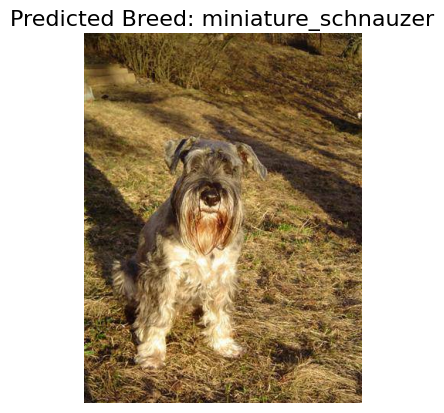

🔥 Final Predicted Breed: miniature_schnauzer


In [43]:
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt

def predict_image():
    uploaded = files.upload()
    file_name = next(iter(uploaded))

    img = Image.open(file_name).convert("RGB")
    x = img_tfms(img).unsqueeze(0).to(device)

    with torch.no_grad():
        p1 = torch.softmax(conv(x), dim=1).cpu().numpy()
        p2 = torch.softmax(swin(x), dim=1).cpu().numpy()
        p3 = torch.softmax(eff(x), dim=1).cpu().numpy()

    # Weighted ensemble (best performance)
    final_prob = 0.70*p1 + 0.25*p2 + 0.05*p3
    pred_idx = final_prob.argmax(axis=1)[0]
    breed = classes[pred_idx]

    # Show result
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted Breed: {breed}", fontsize=16)
    plt.show()

    print(" Final Predicted Breed:", breed)

predict_image()
